# 4.7 Design Deep Reinforcement Learning Agent
## Data Considerations 

In this notebook we will implement some of the considerations necessary to train this model on larger datasets in the scope of > gb. 

In order to do so, we will take the following steps:

1) Save datasets as TFDatasets   
2) Implement iteration on the TFDataset as most models prefer. This is important for distributed learning.   
3) Checkpoint and save models accordingly so they can be loaded again.  
4) Predict on evaluation data.  

#### Download datasets for all the stocks in the S&P 500.

In [1]:
from IPython import display
!pip install gcsfs
!pip install tf-agents[reverb]
display.clear_output()

In [2]:
from google.colab import drive
from google.cloud import storage
import pandas as pd
import time
import pandas as pd 
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function

import abc
import tensorflow as tf
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
import reverb

tf.compat.v1.enable_v2_behavior()

In [3]:
# drive.mount('/content/drive')

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/fin-aml/fin-aml-gcskeys-337dfd8d8867.json"

# storage_client = storage.Client()
# display.clear_output()

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

tempdir = tempfile.gettempdir()

In [5]:
# df = pd.read_csv('gs://fin-datasets-aml/data/sp500/spdfm.csv')
# df.set_index('datetime', inplace=True)
# df.head()

In [6]:
# create toy data to test whether the model works
# 311 time steps of a sine wave, X = 0:310, y = 311
# linspace 0 311 as columns
# rows of different unique waves in A, B, C, D
# maybe something like 5000 rows to start with
import numpy as np
feature_space = np.linspace(0, 311, 311).reshape(1, 311)

A = np.random.normal(0, .1, size=5000).reshape(5000,1)
B = np.random.normal(0, .1, size=5000).reshape(5000, 1)
C = np.random.normal(0, 3, size=5000).reshape(5000, 1)
D = np.random.normal(0, 100, size=5000).reshape(5000, 1)


Xy = np.sin(np.matmul(C, feature_space)*(2*np.pi) - D) * A + B
# X = np.matmul(, A) + B
# X.shape
Xy.shape

(5000, 311)

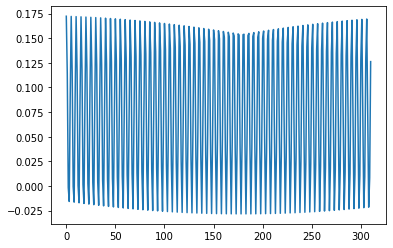

In [7]:
import matplotlib.pyplot as plt

plt.plot(Xy[3]);

In [8]:
import pandas as pd 

Xdf = pd.DataFrame(Xy)
Xdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310
0,-0.159343,-0.188872,0.009300,0.146388,0.022622,-0.181641,-0.168741,0.042524,0.144290,-0.011741,-0.198194,-0.143362,0.072852,0.135371,-0.046909,-0.208363,-0.113713,0.099113,0.119976,-0.081526,-0.211757,-0.080938,0.120295,0.098698,-0.114258,-0.208244,-0.046300,0.135583,0.072357,-0.143842,-0.197960,-0.011134,0.144385,0.041969,-0.169138,-0.181301,0.023203,0.146363,0.008705,-0.189170,-0.158910,0.055389,0.141442,-0.026152,-0.203167,-0.131651,0.084181,0.129809,-0.061258,-0.210589,...,0.013067,-0.186935,-0.162059,0.051445,0.142450,-0.021661,-0.201738,-0.135366,0.080735,0.131654,-0.056810,-0.210020,-0.104711,0.105656,0.114525,-0.091028,-0.211463,-0.071277,0.125245,0.091723,-0.122993,-0.206010,-0.036353,0.138748,0.064128,-0.151474,-0.193873,-0.001284,0.145645,0.032802,-0.175372,-0.175519,0.032576,0.145668,-0.001045,-0.193767,-0.151655,0.063924,0.138819,-0.036110,-0.205949,-0.123202,0.091549,0.125359,-0.071040,-0.211449,-0.091257,0.114387,0.105810,-0.104489
1,-0.011388,-0.008898,-0.007982,-0.008678,-0.010957,-0.014722,-0.019810,-0.026004,-0.033039,-0.040612,-0.048399,-0.056067,-0.063286,-0.069747,-0.075174,-0.079333,-0.082047,-0.083199,-0.082739,-0.080688,-0.077133,-0.072227,-0.066180,-0.059251,-0.051737,-0.043960,-0.036254,-0.028949,-0.022358,-0.016763,-0.012405,-0.009470,-0.008084,-0.008306,-0.010128,-0.013470,-0.018189,-0.024084,-0.030901,-0.038349,-0.046108,-0.053845,-0.061229,-0.067944,-0.073701,-0.078254,-0.081408,-0.083027,-0.083042,-0.081452,...,-0.081586,-0.078545,-0.074092,-0.068418,-0.061766,-0.054422,-0.046700,-0.038931,-0.031448,-0.024572,-0.018598,-0.013782,-0.010329,-0.008389,-0.008044,-0.009310,-0.012131,-0.016387,-0.021895,-0.028420,-0.035682,-0.043369,-0.051152,-0.058697,-0.065682,-0.071805,-0.076806,-0.080470,-0.082639,-0.083221,-0.082190,-0.079592,-0.075537,-0.070198,-0.063806,-0.056634,-0.048989,-0.041199,-0.033598,-0.026512,-0.020244,-0.015064,-0.011192,-0.008796,-0.007978,-0.008773,-0.011146,-0.014997,-0.020160,-0.026413
2,-0.112250,-0.068814,-0.054659,-0.101011,-0.105615,-0.058315,-0.063457,-0.109698,-0.095028,-0.051809,-0.075385,-0.113746,-0.082265,-0.050392,-0.088440,-0.112473,-0.069473,-0.054300,-0.100426,-0.106095,-0.058801,-0.062877,-0.109332,-0.095683,-0.052041,-0.074682,-0.113659,-0.082987,-0.050329,-0.087731,-0.112682,-0.070139,-0.053954,-0.099832,-0.106563,-0.059299,-0.062307,-0.108951,-0.096332,-0.052287,-0.073982,-0.113557,-0.083707,-0.050284,-0.087020,-0.112874,-0.070810,-0.053624,-0.099229,-0.107018,...,-0.055120,-0.101716,-0.105010,-0.057735,-0.064182,-0.110129,-0.094214,-0.051547,-0.076253,-0.113829,-0.081380,-0.050490,-0.089304,-0.112197,-0.068665,-0.054743,-0.101143,-0.105505,-0.058206,-0.063590,-0.109780,-0.094878,-0.051759,-0.075545,-0.113763,-0.082102,-0.050408,-0.088600,-0.112424,-0.069323,-0.054380,-0.100560,-0.105987,-0.058689,-0.063008,-0.109416,-0.095535,-0.051987,-0.074841,-0.113680,-0.082823,-0.050342,-0.087892,-0.112636,-0.069987,-0.054032,-0.099968,-0.106458,-0.059184,-0.062435
3,0.172258,0.114236,-0.001528,-0.015686,0.091250,0.172084,0.115548,-0.000536,-0.016379,0.089827,0.171890,0.116850,0.000470,-0.017054,0.088400,0.171675,0.118144,0.001491,-0.017711,0.086969,0.171439,0.119427,0.002527,-0.018349,0.085535,0.171183,0.120701,0.003577,-0.018968,0.084099,0.170907,0.121965,0.004642,-0.019568,0.082660,0.170610,0.123219,0.005721,-0.020149,0.081219,0.170293,0.124462,0.006813,-0.020711,0.079777,0.169955,0.125694,0.007919,-0.021254,0.078332,...,0.165247,0.064698,-0.025405,0.018965,0.136733,0.165791,0.066142,-0.025048,0.017743,0.135614,0.166316,0.067588,-0.024672,0.016532,0.134483,0.166821,0.069034,-0.024275,0.015333,0.133339,0.167307,0.070481,-0.023859,

In [9]:
X = np.array(Xy[:, :310], dtype=np.float32)
y = np.array(Xy[:, 310], dtype=np.float32)
X.shape, y.shape

((5000, 310), (5000,))

#### Transform the numpy array into TF Dataset 

In [12]:
tf.data.Dataset.from_tensor_slices((X, y))

<TensorSliceDataset shapes: ((310,), ()), types: (tf.float32, tf.float32)>

In [13]:
Xy_dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [14]:
for a,b in Xy_dataset.take(1):
  print(a)
  print(b)

tf.Tensor(
[-0.15934335 -0.18887204  0.00929992  0.14638816  0.022622   -0.18164137
 -0.16874091  0.04252429  0.14428984 -0.01174124 -0.198194   -0.14336176
  0.07285167  0.13537113 -0.04690933 -0.20836307 -0.11371302  0.09911285
  0.11997586 -0.08152642 -0.21175654 -0.08093777  0.12029537  0.0986976
 -0.11425789 -0.20824356 -0.04629959  0.13558257  0.07235669 -0.14384185
 -0.19795959 -0.01113392  0.14438505  0.04196865 -0.16913772 -0.1813011
  0.02320348  0.14636348  0.00870505 -0.18917024 -0.15891033  0.05538879
  0.14144157 -0.02615167 -0.20316711 -0.13165054  0.08418116  0.12980908
 -0.06125767 -0.21058871 -0.10057266  0.10847052  0.11191447 -0.09525949
 -0.21114887 -0.06687488  0.12732045  0.08844765 -0.12684624 -0.20482604
 -0.03185636  0.14000422  0.06031335 -0.15480013 -0.19186395  0.00313282
  0.14603283  0.02859624 -0.17804347 -0.17276236  0.0367437   0.14517383
 -0.00548087 -0.19568011 -0.1482577   0.06768047  0.13746035 -0.04060419
 -0.20703013 -0.1192947   0.0947504   0.12

In [34]:
def _floatlist_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [35]:
_floatlist_feature(a)

float_list {
  value: -0.15934334695339203
  value: -0.18887203931808472
  value: 0.009299922734498978
  value: 0.14638815820217133
  value: 0.02262200228869915
  value: -0.1816413700580597
  value: -0.168740913271904
  value: 0.04252428561449051
  value: 0.14428983628749847
  value: -0.011741237714886665
  value: -0.1981939971446991
  value: -0.14336176216602325
  value: 0.07285166531801224
  value: 0.135371133685112
  value: -0.04690932855010033
  value: -0.20836307108402252
  value: -0.11371301859617233
  value: 0.0991128459572792
  value: 0.11997586488723755
  value: -0.08152642101049423
  value: -0.21175654232501984
  value: -0.08093776553869247
  value: 0.12029536813497543
  value: 0.09869760274887085
  value: -0.11425789445638657
  value: -0.20824356377124786
  value: -0.046299587935209274
  value: 0.1355825662612915
  value: 0.0723566859960556
  value: -0.14384184777736664
  value: -0.19795958697795868
  value: -0.011133921332657337
  value: 0.14438505470752716
  value: 0.04196

In [36]:
_float_feature(b)

float_list {
  value: -0.10448912531137466
}

In [37]:
def serialize_example(x,y):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'x': _floatlist_feature(x),
      'y': _float_feature(y)
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [51]:
X.shape, y.shape

((5000, 310), (5000,))

In [53]:
X[0].shape, y[0].shape

((310,), ())

In [55]:
filename = 'test2.tfrecord'
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(X.shape[0]):
    example = serialize_example(X[i],y[i])
    writer.write(example)

In [56]:
raw_dataset = tf.data.TFRecordDataset([filename])

for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "x"
    value {
      float_list {
        value: -0.15934334695339203
        value: -0.18887203931808472
        value: 0.009299922734498978
        value: 0.14638815820217133
        value: 0.02262200228869915
        value: -0.1816413700580597
        value: -0.168740913271904
        value: 0.04252428561449051
        value: 0.14428983628749847
        value: -0.011741237714886665
        value: -0.1981939971446991
        value: -0.14336176216602325
        value: 0.07285166531801224
        value: 0.135371133685112
        value: -0.04690932855010033
        value: -0.20836307108402252
        value: -0.11371301859617233
        value: 0.0991128459572792
        value: 0.11997586488723755
        value: -0.08152642101049423
        value: -0.21175654232501984
        value: -0.08093776553869247
        value: 0.12029536813497543
        value: 0.09869760274887085
        value: -0.11425789445638657
        value: -0.20824356377124786
        value

In [62]:
## Recreate the dataset from test2.tfrecord

raw_xy_dataset = tf.data.TFRecordDataset('test2.tfrecord')

dataset_key = {
    'x': tf.io.FixedLenFeature([310,], tf.float32),
    'y': tf.io.FixedLenFeature([], tf.float32)
}

def _parse_xy_function(example_proto):
  return tf.io.parse_single_example(example_proto, dataset_key)

parsed_xy_dataset = raw_xy_dataset.map(_parse_xy_function)
parsed_xy_dataset

<MapDataset shapes: {x: (310,), y: ()}, types: {x: tf.float32, y: tf.float32}>

In [64]:
for xy in parsed_xy_dataset.take(1):
  print(xy['x'])
  print(xy['y'])

tf.Tensor(
[-0.15934335 -0.18887204  0.00929992  0.14638816  0.022622   -0.18164137
 -0.16874091  0.04252429  0.14428984 -0.01174124 -0.198194   -0.14336176
  0.07285167  0.13537113 -0.04690933 -0.20836307 -0.11371302  0.09911285
  0.11997586 -0.08152642 -0.21175654 -0.08093777  0.12029537  0.0986976
 -0.11425789 -0.20824356 -0.04629959  0.13558257  0.07235669 -0.14384185
 -0.19795959 -0.01113392  0.14438505  0.04196865 -0.16913772 -0.1813011
  0.02320348  0.14636348  0.00870505 -0.18917024 -0.15891033  0.05538879
  0.14144157 -0.02615167 -0.20316711 -0.13165054  0.08418116  0.12980908
 -0.06125767 -0.21058871 -0.10057266  0.10847052  0.11191447 -0.09525949
 -0.21114887 -0.06687488  0.12732045  0.08844765 -0.12684624 -0.20482604
 -0.03185636  0.14000422  0.06031335 -0.15480013 -0.19186395  0.00313282
  0.14603283  0.02859624 -0.17804347 -0.17276236  0.0367437   0.14517383
 -0.00548087 -0.19568011 -0.1482577   0.06768047  0.13746035 -0.04060419
 -0.20703013 -0.1192947   0.0947504   0.12

I have successfully saved hte data in TFRecord format as required for TPU training. Now, in order to use it to train I have to make some changes to my modelling. Namely, I have to ensure the TFRecord is what is being read in the environment, and furthermore ensure that it is able to be distributed for training. 

#### Build an environment to represent this movement

In [ ]:
X[0].shape

(310,)

In [ ]:
class StockMarketEnv(py_environment.PyEnvironment):
    '''
    Observation: The observation should be a (90,505) matrix
    Action: A (505) vector with probabilties from 0 1, max 10 are encoded as 1, all others are 0
    Reward: dot product of the (505,1) top 10 choices with the next (1,505) returns
    '''
    def __init__(self, X, y):
        self._action_spec = array_spec.BoundedArraySpec(
                                    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
                                    shape=(310,), dtype=np.float32, minimum=-1, maximum=1 ,name='observation')
        self._X = X
        self._y = y
        self._i = 0
        self._state = np.array(self._X[self._i], dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._i = 0
        self._state = np.array(self._X[self._i], dtype=np.float32) ## input array
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()

        self._i += 1

        if self._i + 1 >= self._y.shape[0]:
            self._episode_ended = True
        
        reward_state = np.array(self._y[self._i], dtype=np.float32)
        reward = -(action[0] - reward_state)**2
        
        self._state = np.array(self._X[self._i], dtype=np.float32)
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32))
        else:
            return ts.transition(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32), discount=1.0)

In [ ]:
environment = StockMarketEnv(X, y)
utils.validate_py_environment(environment, episodes=5)

##### Train a DQN to learn on it

In [ ]:
# Important interval values for training speed
# Set lower to increase speed of training 

num_iterations = 10 # @param {type:"integer"}
log_interval = 100 # @param {type:"integer"}=
num_eval_episodes = 1 # @param {type:"integer"}
eval_interval = 1 # @param {type:"integer"}

In [ ]:
initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (310,)
critic_joint_fc_layer_params = (310,)



policy_save_interval = 5000 # @param {type:"integer"}

In [ ]:
X.shape[0], X.shape[0]//2

(5000, 2500)

In [ ]:
y.shape[0],  y.shape[0]//2

(5000, 2500)

In [ ]:
# Code to produce tf environments
# train_py_env = StockMarketEnv(X[:X.shape[0]//2])
# eval_py_env = StockMarketEnv(X[X.shape[0]//2:])
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Code to produce py environments 
train_env = StockMarketEnv(X[:X.shape[0]//2], y[:y.shape[0]//2])
eval_env = StockMarketEnv(X[X.shape[0]//2:], y[y.shape[0]//2:])

In [ ]:
train_env._y, eval_env._y

(array([ 0.02279128, -0.04242661,  0.08742822, ..., -0.22473535,
        -0.00361564, -0.16828975], dtype=float32),
 array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
        -0.07825399,  0.1870721 ], dtype=float32))

In [ ]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)
print('Action Spec:')
print(train_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(310,), dtype=dtype('float32'), name='observation', minimum=-1.0, maximum=1.0)
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=0.0, maximum=1.0)


In [ ]:
use_gpu = False 

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [ ]:
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork((observation_spec, action_spec),
                                            observation_fc_layer_params=None,
                                            action_fc_layer_params=None,
                                            joint_fc_layer_params=critic_joint_fc_layer_params,
                                            kernel_initializer='glorot_uniform',
                                            last_kernel_initializer='glorot_uniform')

In [ ]:
action_spec

BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))

In [ ]:
observation_spec

BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32))

In [ ]:
actor_fc_layer_params

(310,)

In [ ]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(observation_spec,
                                                                    action_spec,
                                                                    fc_layer_params=actor_fc_layer_params,
                                                                    continuous_projection_net=(
                                              tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [ ]:
time_step_spec

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32)))

In [ ]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
                                time_step_spec,
                                action_spec,
                                actor_network=actor_net,
                                critic_network=critic_net,
                                actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=actor_learning_rate),
                                critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=critic_learning_rate),
                                alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=alpha_learning_rate),
                                target_update_tau=target_update_tau,
                                target_update_period=target_update_period,
                                td_errors_loss_fn=tf.math.squared_difference,
                                gamma=gamma,
                                reward_scale_factor=reward_scale_factor,
                                train_step_counter=train_step)

    tf_agent.initialize()

In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  train_env.time_step_spec(), train_env.action_spec())

In [ ]:
initial_collect_actor = actor.Actor(
              train_env,
              random_policy,
              train_step,
              steps_per_run=initial_collect_steps,
              observers=[rb_observer])
initial_collect_actor.run()

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
                  train_env,
                  collect_policy,
                  train_step,
                  steps_per_run=1,
                  metrics=actor.collect_metrics(10),
                  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
                  observers=[rb_observer, env_step_metric])

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [ ]:
%%time
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

CPU times: user 3.45 s, sys: 275 ms, total: 3.72 s
Wall time: 3.29 s


In [ ]:
eval_env._y

array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
       -0.07825399,  0.1870721 ], dtype=float32)

In [ ]:
%%time
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
              '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -843.354919, AverageEpisodeLength = 2499.000000
CPU times: user 462 µs, sys: 0 ns, total: 462 µs
Wall time: 471 µs


In [ ]:
training_params = [num_iterations,
                    log_interval,
                    num_eval_episodes,
                    eval_interval]
          
print(training_params)

[10, 100, 1, 1]


In [ ]:
#@test {"skip": true}
try:
    %%time
except:
    pass

start = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = metrics["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))
        minsec = divmod((time.time() - start), 60)
        hourmin = divmod(minsec[0], 60)
        print(f"Time elasped: {int(hourmin[0])}:{int(hourmin[1])}:{minsec[1]}")

rb_observer.close()
reverb_server.stop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
step = 1: AverageReturn = -841.190735, AverageEpisodeLength = 2499.000000
step = 2: AverageReturn = -858.180542, AverageEpisodeLength = 2499.000000
step = 3: AverageReturn = -866.887695, AverageEpisodeLength = 2499.000000
step = 4: AverageReturn = -883.350037, AverageEpisodeLength = 2499.000000
step = 5: AverageReturn = -880.205139, AverageEpisodeLength = 2499.000000
step = 6: AverageReturn = -908.121765, AverageEpisodeLength = 2499.000000
step = 7: AverageReturn = -864.832520, AverageEpisodeLength = 2499.000000
step = 8: AverageReturn = -870.467529, AverageEpisodeLength = 2499.000000
step = 9: AverageReturn = -873.192322, AverageEpisodeLength = 2499.000000
step = 10: AverageReturn = -837.118347, AverageEpisodeLength = 2499.000000


(-911.6719360351562, -833.5681762695312)

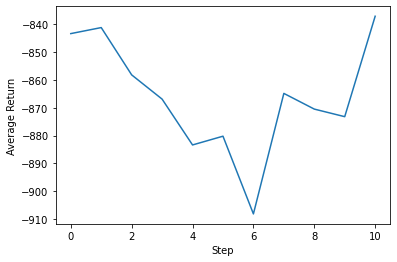

In [ ]:
#@test {"skip": true}

steps = range(0, 11, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [ ]:
for metric in collect_actor.metrics:
  print(f"{metric.name} = {metric.result()}")

NumberOfEpisodes = 0
EnvironmentSteps = 10
AverageReturn = 0.0
AverageEpisodeLength = 0.0


In [ ]:
collect_actor.metrics[2].result()

array(0., dtype=float32)